## Прогноз качества красного вина на основе физико-химических показателей  
**Студент:** Галиев И. Р.  
**Руководитель:** Алексей Астахов

**Дата:** май 2025

### Цели работы  
- **Разработать** модель машинного обучения для бинарной классификации качества красного вина (good/bad)  
- **Автоматизировать** предварительную оценку качества по физико-химическим признакам  

### Задачи  
1. Собрать и описать данные (EDA)  
2. Выполнить предобработку: обработка пропусков и выбросов  
3. Сформулировать и проверить не менее двух статистических гипотез  
4. Построить и сравнить не менее пяти моделей ML  
5. Выбрать лучшую модель и сохранить её (joblib/pickle)  
6. Подготовить интерфейс для предсказания на новых данных  

### 2.1 Обзор литературы  
- **Что изучено:** влияние уровня алкоголя, SO₂ и кислотности на органолептические свойства вина.  
- **Существующие решения:** регрессионные и классификационные модели на данных UCI Wine Quality.  
- **Сложности:**  
  - Сильно скошенные распределения признаков (SO₂, сахар)  
  - Слабая линейная связь многих переменных с оценкой качества  
- **Современное состояние:**  
  - Применение градиентного бустинга (XGBoost, LightGBM)  
  - Использование ансамблей и методов отбора признаков  

- Источник: [Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/code?datasetId=4458&sortBy=dateRun&tab=profile&excludeNonAccessedDatasources=false) (только красные вина)  
- Количество записей: 1599  
- Признаки:
  - fixed acidity, volatile acidity, citric acid  
  - residual sugar, chlorides, free sulfur dioxide  
  - total sulfur dioxide, density, pH, sulphates, alcohol  
- Целевая переменная:
  - `quality` (0–10) → бинаризовано в `good` (1: ≥7) / `bad` (0: <7)
- Эти два набора данных относятся к разновидностям красного португальского вина «Винью Верде». Для получения более подробной информации обратитесь к ссылке [Cortez et al., 2009]. Из-за соображений конфиденциальности и логистики доступны только физико-химические (входные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т. д.).

# Загрузка и разведка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set plotting style
sns.set(style="whitegrid")

In [3]:
# Load datasets (ensure CSV files are in the `data/` directory)
df = pd.read_csv('winequality-red.csv')

In [4]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
# Basic statistics and missing values
print(df.describe())
print("Missing values per column:\n", df.isnull().sum())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [6]:
def label_quality(q):
    return 1 if q > 6.5 else 0

In [7]:
df['good'] = df['quality'].apply(label_quality)

In [8]:
# Show counts
print(df['good'].value_counts())

good
0    1382
1     217
Name: count, dtype: int64


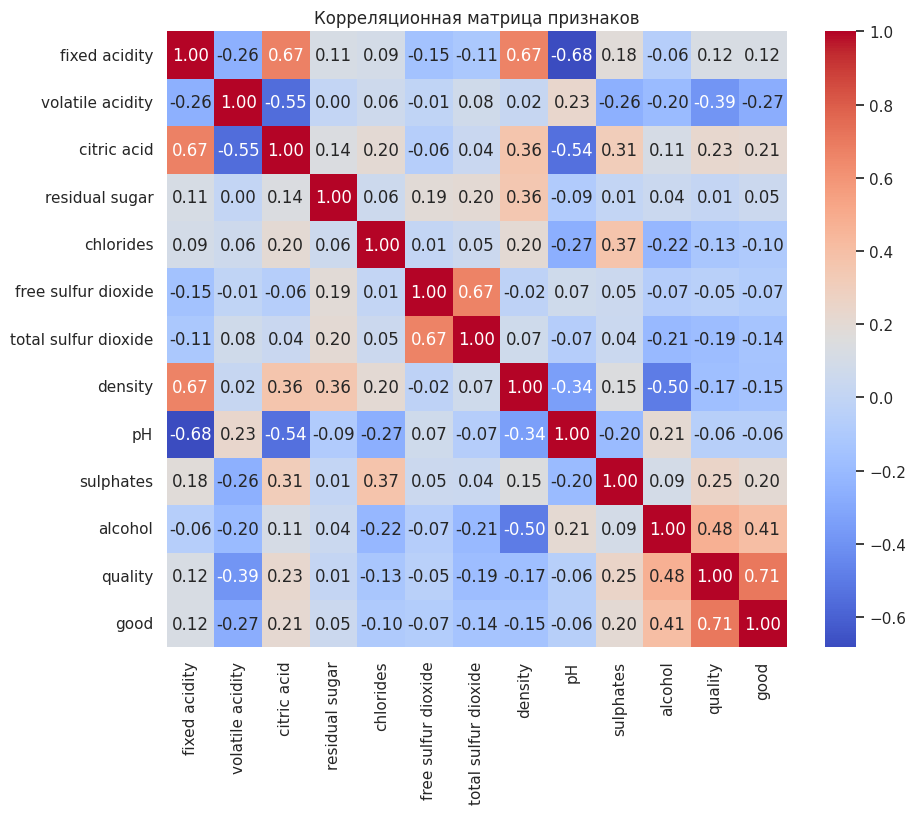

In [9]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица признаков")
plt.show()

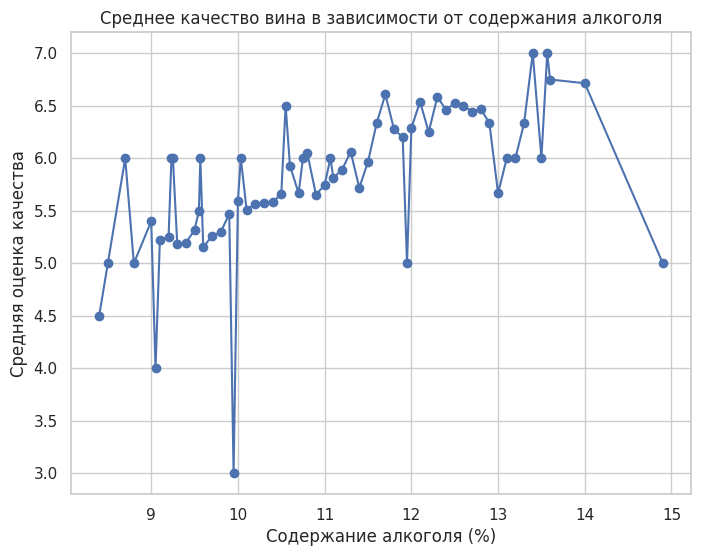

In [10]:
mean_quality = df.groupby('alcohol')['quality'].mean()

plt.figure(figsize=(8, 6))
plt.plot(mean_quality.index, mean_quality.values, marker='o')
plt.title('Среднее качество вина в зависимости от содержания алкоголя')
plt.xlabel('Содержание алкоголя (%)')
plt.ylabel('Средняя оценка качества')
plt.grid(True)
plt.show()

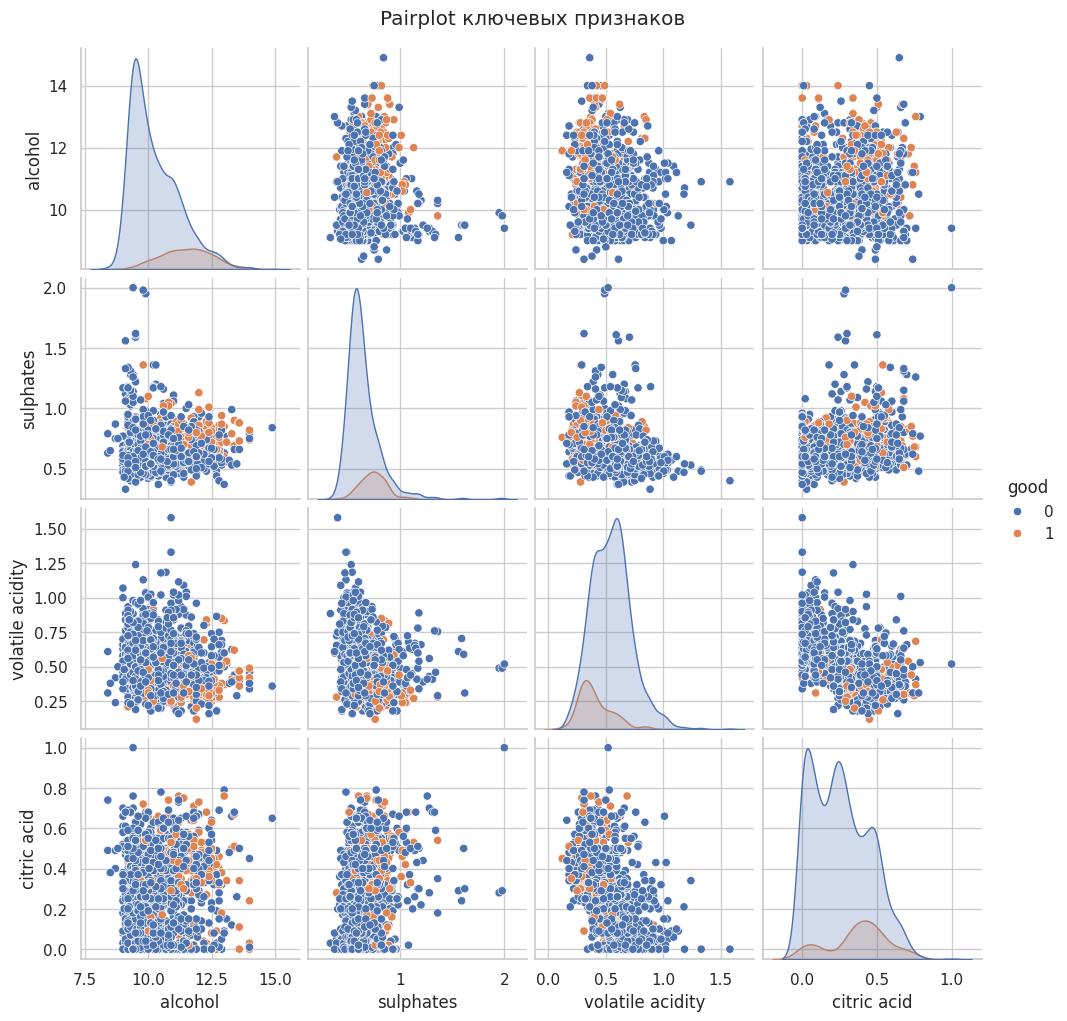

In [11]:
sns.pairplot(df, vars=["alcohol","sulphates","volatile acidity","citric acid"], hue="good", diag_kind="kde")
plt.suptitle("Pairplot ключевых признаков", y=1.02)
plt.show()

<ipython-input-12-7ffb058a101f>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[col] for col in df.select_dtypes(include=float)],


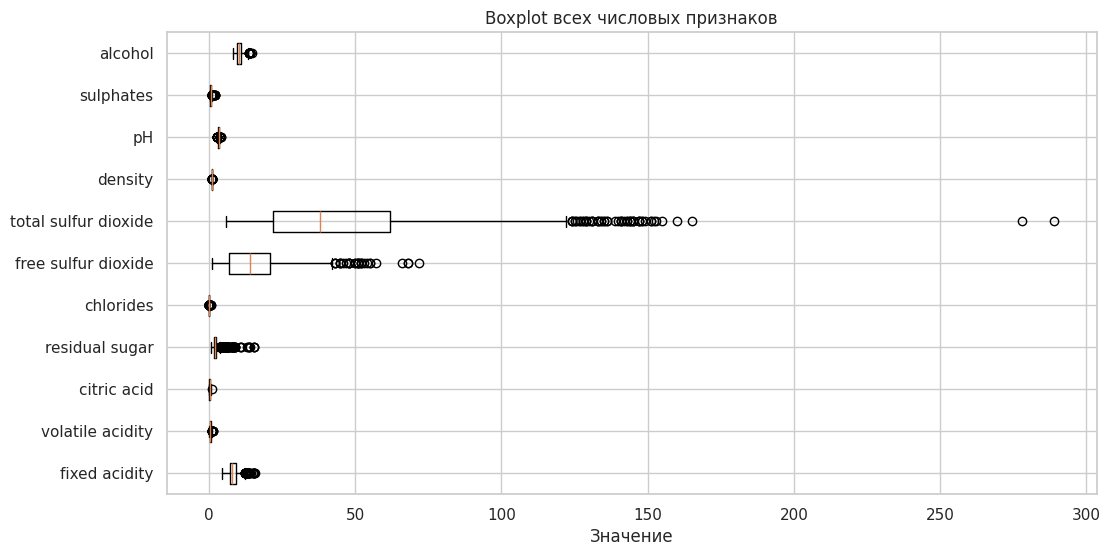

In [12]:
plt.figure(figsize=(12, 6))
# горизонтальный boxplot сразу для всех числовых столбцов
plt.boxplot([df[col] for col in df.select_dtypes(include=float)],
            labels=df.select_dtypes(include=float).columns,
            vert=False)
plt.title("Boxplot всех числовых признаков")
plt.xlabel("Значение")
plt.show()

In [13]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Пример: убираем выбросы по total sulfur dioxide
df_no_out = remove_outliers_iqr(df, 'total sulfur dioxide')
df_no_out

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


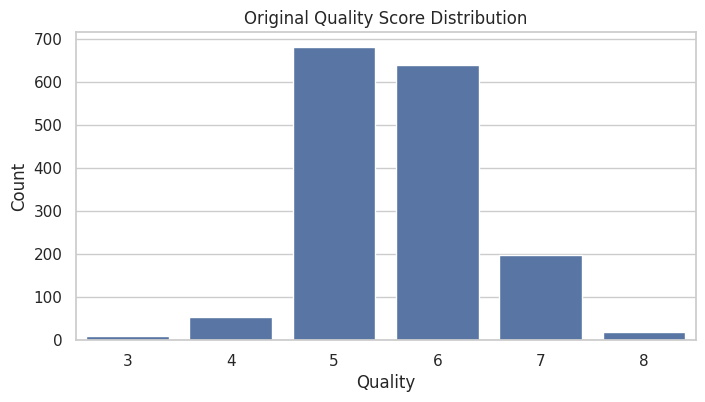

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='quality', data=df)
plt.title('Original Quality Score Distribution')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()


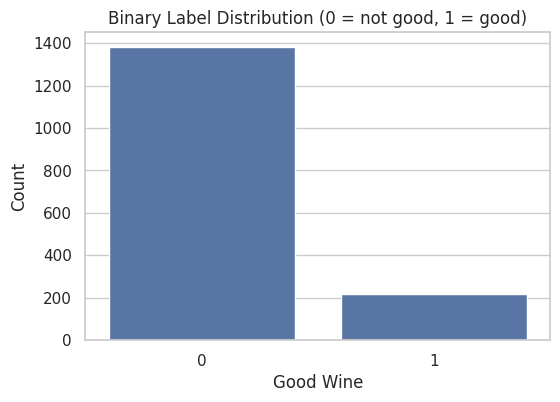

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x='good', data=df)
plt.title('Binary Label Distribution (0 = not good, 1 = good)')
plt.xlabel('Good Wine')
plt.ylabel('Count')
plt.show()

# Проверка гипотез

### Гипотеза 1  
Влияет ли количество алкоголя на качества вина.
- H₀: нет корреляции alcohol ↔ quality  
- H₁: есть корреляция

In [16]:
from scipy import stats

# 1) Нормальность
_, p_alc = stats.shapiro(df['alcohol'])
_, p_qual = stats.shapiro(df['quality'])
print("Shapiro p-values:", p_alc, p_qual)

r, p = stats.pearsonr(df['alcohol'], df['quality'])
print(f"Pearson r={r:.3f}, p={p:.3e}")

rho, p_s = stats.spearmanr(df['alcohol'], df['quality'])
print(f"Spearman ρ={rho:.3f}, p={p_s:.3e}")

Shapiro p-values: 6.644056905730039e-27 9.515084999430088e-36
Pearson r=0.476, p=2.831e-91
Spearman ρ=0.479, p=2.727e-92


Вердикт: есть умеренно-положительная корреляция от количества алкоголя к качеству вина, ведь p < 0.05



---



### Гипотеза 2
Средняя концентрация SO₂ одинаковая в хоршем и плохом вине
- H₀: медианы free SO₂ в good/bad равны  
- H₁: медианы отличаются

In [17]:
# Разделим выборку
good = df[df['good']==1]['free sulfur dioxide']
bad  = df[df['good']==0]['free sulfur dioxide']

# 1) Нормальность в группах
_, p1 = stats.shapiro(good)
_, p2 = stats.shapiro(bad)
print("Shapiro (good/bad):", p1, p2)

# 2) Равенство дисперсий
_, p_levene = stats.levene(good, bad)
print("Levene p =", p_levene)

# 3) Выбираем тест:
if p1>0.05 and p2>0.05 and p_levene>0.05:
    # классический t-тест
    stat, p_val = stats.ttest_ind(good, bad)
    print(f"t-test t={stat:.3f}, p={p_val:.3e}")
else:
    # непараметрический
    stat, p_val = stats.mannwhitneyu(good, bad, alternative='two-sided')
    print(f"Mann-Whitney U={stat:.3f}, p={p_val:.3e}")

Shapiro (good/bad): 8.5864287310089e-14 3.660736830371343e-28
Levene p = 0.18546128282293012
Mann-Whitney U=127454.000, p=3.705e-04


Вердикт: Таким образом мы провердили, что медианы free SO₂ в good/bad отличаются, ведь p < 0.05



---



### Гипотеза 3
pH (кислотность) влияет на то, попало ли вино в категорию «good».
- H₀: распределения (или медианы) pH в винах, классифицированных как «good» и «bad», одинаковы.
- H₁: распределения (медианы) pH в «good» и «bad» отличаются.

In [18]:
# Разделим выборку по бинарному таргету
ph_good = df[df['good']==1]['pH']
ph_bad  = df[df['good']==0]['pH']

# 1) Проверка нормальности Shapiro–Wilk
_, p1 = stats.shapiro(ph_good)
_, p2 = stats.shapiro(ph_bad)
print("Shapiro p-values (good/bad):", p1, p2)

# 2) Проверка равенства дисперсий Levene
_, p_levene = stats.levene(ph_good, ph_bad)
print("Levene p-value:", p_levene)

# 3) Выбор теста
if p1>0.05 and p2>0.05 and p_levene>0.05:
    # обе группы нормальны и дисперсии похожи → t-test
    stat, p_val = stats.ttest_ind(ph_good, ph_bad)
    print(f"t-test: t={stat:.3f}, p={p_val:.3e}")
else:
    # иначе непараметрический Mann–Whitney U
    stat, p_val = stats.mannwhitneyu(ph_good, ph_bad, alternative='two-sided')
    print(f"Mann–Whitney U={stat:.3f}, p={p_val:.3e}")

Shapiro p-values (good/bad): 0.011935811321722856 6.388903716135676e-06
Levene p-value: 0.8139427104343837
Mann–Whitney U=133127.500, p=7.804e-03


Вердикт: уровень кислотности (pH) статистически значимо различается в «хорошем» и «плохом» вине

# Препроцессинг

Перед обучением моделей был выполнен следующий комплекс шагов по подготовке данных:
1. **Фильтрация только красного вина**  
   — из исходного датасета UCI Wine Quality оставлены записи лишь о красном вине, так как наша задача сфокусирована на этом типе.

2. **Бинаризация таргета**  
   — признак `quality` (0–10) преобразован в новый бинарный `good`.

3. **PCA**

   — Берем только признаки которые описывают 99% таргета.

4. **Скейлинг**

   — Делаем скейл признаков, чтобы они вносили вклад в результата не из-за значений, а из-за их реального значения.

In [19]:
X = df.drop(columns=['quality', 'good'])
y = df['good']

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 1199, Test size: 400


In [22]:
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1294,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9
1584,6.7,0.320,0.44,2.4,0.061,24.0,34.0,0.99484,3.29,0.80,11.6
832,10.4,0.440,0.42,1.5,0.145,34.0,48.0,0.99832,3.38,0.86,9.9
681,8.0,0.450,0.23,2.2,0.094,16.0,29.0,0.99620,3.21,0.49,10.2
418,11.9,0.380,0.51,2.0,0.121,7.0,20.0,0.99960,3.24,0.76,10.4
...,...,...,...,...,...,...,...,...,...,...,...
1533,8.0,0.390,0.30,1.9,0.074,32.0,84.0,0.99717,3.39,0.61,9.0
508,10.0,0.590,0.31,2.2,0.090,26.0,62.0,0.99940,3.18,0.63,10.2
1090,10.0,0.260,0.54,1.9,0.083,42.0,74.0,0.99451,2.98,0.63,11.8
1027,6.4,0.795,0.00,2.2,0.065,28.0,52.0,0.99378,3.49,0.52,11.6


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=0.99, random_state=42)

pipeline = Pipeline([
    ('scale', scaler),
    ('pca', pca)
])

In [24]:
pipeline.fit(X_train, y_train)
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [25]:
X_train_transformed.shape

(1199, 10)

# Обучение моделей

Использовал 3 подхода:
- Обучал просто модели на сырых данных без препроцессинга + калибровка.
- Обучал на данных с препроцессинга (PCA + StandartScaler) + калибровка + gridSearch.
- Обучил без препроцессинга, но с калибровкой и gridSearch, так как заскейленные данные показани результата хуже обычных.

In [26]:
!pip install catboost

In [27]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [29]:
models = {
    'lr': LogisticRegression(solver='liblinear', random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'ada': AdaBoostClassifier(random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'dt': DecisionTreeClassifier(random_state=42),
    'xb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'lb': LGBMClassifier(random_state=42),
    'cb': CatBoostClassifier(verbose=0, random_state=42),
    'kn': KNeighborsClassifier()
}

In [30]:
param_grids = {
    'lr': {
        'C': [0.01, 0.1, 1, 10],
        'class_weight': ['balanced', None]
    },
    'kn': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'dt': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'rf': {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10]
    },
    'gb': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'xb': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'lb': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1]
    },
    'cb': {
        'iterations': [100, 200],
        'learning_rate': [0.05, 0.1]
    }
}

На сырых данных без препроцессинга + калибровка.

In [31]:
results = []
save_default = {}

for name, model in models.items():
  print(name, model)
  cross_val_res = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)


  best = model
  best.fit(X_train, y_train)
  y_pred = best.predict(X_test)
  try:
    y_proba = best.predict_proba(X_test)[:,1]
  except Exception as e:
    print(e)

  save_default[name] = [best]

  calibrator = CalibratedClassifierCV(
      estimator=best,
      method='sigmoid',
      cv=5
  )
  calibrator.fit(X_train, y_train)
  y_proba_cal = calibrator.predict_proba(X_test)[:,1]

  print("Calibrated Brier score:",
        brier_score_loss(y_test, y_proba_cal))
  calibrated = roc_auc_score(y_test, y_proba_cal)
  print("Calibrated ROC-AUC:", calibrated)

  acc = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_proba)

  results.append({
        'model': name,
        'cv_auc_mean': cross_val_res.mean(),
        'test_acc': acc,
        'test_auc': roc_auc,
        'calibrated_roc_auc': calibrated

    })

  save_default[name].append(calibrator)

lr LogisticRegression(random_state=42, solver='liblinear')
Calibrated Brier score: 0.08992409388261047
Calibrated ROC-AUC: 0.8468208092485549
rf RandomForestClassifier(random_state=42)
Calibrated Brier score: 0.0530632668391011
Calibrated ROC-AUC: 0.9446050096339114
ada AdaBoostClassifier(random_state=42)
Calibrated Brier score: 0.08345030118430298
Calibrated ROC-AUC: 0.8828409334189681
gb GradientBoostingClassifier(random_state=42)
Calibrated Brier score: 0.06680908838876193
Calibrated ROC-AUC: 0.9131342324983943
dt DecisionTreeClassifier(random_state=42)
Calibrated Brier score: 0.07951701297361889
Calibrated ROC-AUC: 0.8751070434596446
xb XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Calibrated Brier score: 0.052826863919339336
Calibrated ROC-AUC: 0.946959965746093
lb LGBMClassifier(random_state=42)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 163, number of negative: 1036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 1199, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135947 -> initscore=-1.849372
[LightGBM] [Info] Start training from score -1.849372
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 131, number of negative: 828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 second

In [32]:
print(pd.DataFrame(results).sort_values('test_auc', ascending=False))

  model  cv_auc_mean  test_acc  test_auc  calibrated_roc_auc
5    xb     0.874583    0.9425  0.952366            0.946960
1    rf     0.893581    0.9400  0.949743            0.944605
6    lb     0.888569    0.9400  0.938718            0.940109
7    cb     0.893604    0.9175  0.932402            0.939039
3    gb     0.887331    0.9075  0.897934            0.913134
2   ada     0.863030    0.8900  0.872752            0.882841
0    lr     0.869561    0.8700  0.847998            0.846821
8    kn     0.779553    0.8650  0.777189            0.766699
4    dt     0.694367    0.8950  0.775209            0.875107


С препроцессинга (PCA + StandartScaler) + калибровка + gridSearch

In [33]:
results_tuned = []
save = {}

for name, model in models.items():
  print(name, model)
  cross_val_res = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

  if name in param_grids:
      gs = GridSearchCV(
          estimator=model,
          param_grid=param_grids[name],
          cv=3,
          scoring='roc_auc',
          n_jobs=-1,
          verbose=1
      )

      gs.fit(X_train_transformed, y_train)
      best = gs.best_estimator_
      y_pred = best.predict(X_test_transformed)
      try:
        y_pred_proba = best.predict_proba(X_test_transformed)[:,1]
      except Exception as e:
        print(e)

      y_proba = y_pred_proba
      save[name] = [best]
  else:
    best = model
    best.fit(X_train_transformed, y_train)
    y_pred = best.predict(X_test_transformed)
    try:
      y_proba = best.predict_proba(X_test_transformed)[:,1]
    except Exception as e:
      print(e)

    save[name] = [best]

  calibrator = CalibratedClassifierCV(
      estimator=best,
      method='sigmoid',
      cv=5
  )
  calibrator.fit(X_train_transformed, y_train)
  y_proba_cal = calibrator.predict_proba(X_test_transformed)[:,1]

  print("Calibrated Brier score:",
        brier_score_loss(y_test, y_proba_cal))
  calibrated = roc_auc_score(y_test, y_proba_cal)
  print("Calibrated ROC-AUC:", calibrated)

  acc = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_proba)

  results_tuned.append({
        'model': name,
        'cv_auc_mean': cross_val_res.mean(),
        'test_acc': acc,
        'test_auc': roc_auc,
        'calibrated_roc_auc': calibrated

    })

  save[name].append(calibrator)

lr LogisticRegression(random_state=42, solver='liblinear')
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Calibrated Brier score: 0.08469714849325508
Calibrated ROC-AUC: 0.8825198030400343
rf RandomForestClassifier(random_state=42)
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Calibrated Brier score: 0.06213535222560772
Calibrated ROC-AUC: 0.9216977092699635
ada AdaBoostClassifier(random_state=42)
Calibrated Brier score: 0.08458372332625086
Calibrated ROC-AUC: 0.8490152001712694
gb GradientBoostingClassifier(random_state=42)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Calibrated Brier score: 0.06456008206707843
Calibrated ROC-AUC: 0.930635838150289
dt DecisionTreeClassifier(random_state=42)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Calibrated Brier score: 0.08770496036945698
Calibrated ROC-AUC: 0.8661956754442304
xb XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_b

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Calibrated Brier score: 0.06604395323625183
Calibrated ROC-AUC: 0.9142581888246628
lb LGBMClassifier(random_state=42)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 163, number of negative: 1036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1199, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135947 -> initscore=-1.849372
[LightGBM] [Info] Start training from score -1.849372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 131, number of negative: 828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 959, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136601 -> initscore=-1.843816
[LightGBM] [Info] Start training from score -1.843816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 130, number of negative: 829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 959, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135558 -> initscore=-1.852686
[LightGBM] [Info] Start training from score -1.852686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 130, number of negative: 829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 959, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135558 -> initscore=-1.852686
[LightGBM] [Info] Start training from score -1.852686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 130, number of negative: 829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 959, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135558 -> initscore=-1.852686
[LightGBM] [Info] Start training from score -1.852686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 131, number of negative: 829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136458 -> initscore=-1.845023
[LightGBM] [Info] Start training from score -1.845023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Calibrated Brier score: 0.06659202802938563
Calibrated ROC-AUC: 0.9105651894669237
cb <catboost.core.CatBoostClassifier object at 0x79ba5af67f90>
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Calibrated Brier score: 0.063622817055038
Calibrated ROC-AUC: 0.9211624919717406
kn KNeighborsClassifier()
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Calibrated Brier score: 0.06225954791828797
Calibrated ROC-AUC: 0.8567223292656818


In [34]:
print(pd.DataFrame(results_tuned).sort_values('test_auc', ascending=False))

  model  cv_auc_mean  test_acc  test_auc  calibrated_roc_auc
1    rf     0.891352    0.9250  0.925444            0.921698
3    gb     0.886668    0.9150  0.915168            0.930636
7    cb     0.901957    0.9125  0.914044            0.921162
5    xb     0.899367    0.9175  0.910298            0.914258
6    lb     0.902168    0.9150  0.909441            0.910565
0    lr     0.871030    0.7700  0.883162            0.882520
8    kn     0.812973    0.9300  0.858810            0.856722
2   ada     0.869717    0.8850  0.840050            0.849015
4    dt     0.688353    0.8825  0.796617            0.866196


Без препроцессинга, но с калибровкой и gridSearch

In [35]:
results_final = []
save_final = {}

for name, model in models.items():
  print(name, model)
  cross_val_res = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

  if name in param_grids:
      gs = GridSearchCV(
          estimator=model,
          param_grid=param_grids[name],
          cv=3,
          scoring='roc_auc',
          n_jobs=-1,
          verbose=1
      )

      gs.fit(X_train, y_train)
      best = gs.best_estimator_
      y_pred = best.predict(X_test)
      try:
        y_pred_proba = best.predict_proba(X_test)[:,1]
      except Exception as e:
        print(e)

      y_proba = y_pred_proba
      save_final[name] = [best]
  else:
    best = model
    best.fit(X_train, y_train)
    y_pred = best.predict(X_test)
    try:
      y_proba = best.predict_proba(X_test)[:,1]
    except Exception as e:
      print(e)

    save_final[name] = [best]

  calibrator = CalibratedClassifierCV(
      estimator=best,
      method='sigmoid',
      cv=5
  )
  calibrator.fit(X_train, y_train)
  y_proba_cal = calibrator.predict_proba(X_test)[:,1]

  print("Calibrated Brier score:",
        brier_score_loss(y_test, y_proba_cal))
  calibrated = roc_auc_score(y_test, y_proba_cal)
  print("Calibrated ROC-AUC:", calibrated)

  acc = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_proba)

  results_final.append({
        'model': name,
        'cv_auc_mean': cross_val_res.mean(),
        'test_acc': acc,
        'test_auc': roc_auc,
        'calibrated_roc_auc': calibrated

    })

  save_final[name].append(calibrator)

lr LogisticRegression(random_state=42, solver='liblinear')
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Calibrated Brier score: 0.08998497381695973
Calibrated ROC-AUC: 0.8553307642903019
rf RandomForestClassifier(random_state=42)
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Calibrated Brier score: 0.05302209680580306
Calibrated ROC-AUC: 0.9431599229287091
ada AdaBoostClassifier(random_state=42)
Calibrated Brier score: 0.08345030118430298
Calibrated ROC-AUC: 0.8828409334189681
gb GradientBoostingClassifier(random_state=42)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Calibrated Brier score: 0.06622220447727294
Calibrated ROC-AUC: 0.9139905801755512
dt DecisionTreeClassifier(random_state=42)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Calibrated Brier score: 0.07806065885880212
Calibrated ROC-AUC: 0.8926086491115391
xb XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:43:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Calibrated Brier score: 0.05668889304665678
Calibrated ROC-AUC: 0.9367373153500322
lb LGBMClassifier(random_state=42)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 163, number of negative: 1036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 1199, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135947 -> initscore=-1.849372
[LightGBM] [Info] Start training from score -1.849372
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 131, number of negative: 828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
Y

In [36]:
print(pd.DataFrame(results_final).sort_values('test_auc', ascending=False))

  model  cv_auc_mean  test_acc  test_auc  calibrated_roc_auc
1    rf     0.893581    0.9400  0.952125            0.943160
5    xb     0.874583    0.9400  0.936470            0.936737
6    lb     0.888569    0.9350  0.935827            0.932188
7    cb     0.893604    0.9375  0.935346            0.945194
3    gb     0.887331    0.9100  0.900610            0.913991
2   ada     0.863030    0.8900  0.872752            0.882841
4    dt     0.694367    0.9075  0.871735            0.892609
0    lr     0.869561    0.7850  0.856134            0.855331
8    kn     0.779553    0.8925  0.822361            0.821505


## Выводы

Была проделана комплексная работа по очистке и подготовке данных, проверке статистических гипотез и обучению различных моделей классификации. GridSearch и калибровка позволили улучшить метрики, особенно в контексте предсказания вероятностей.

Наилучшие результаты показали модель беггинга (Random Forest Tree), что подтверждает их эффективность на небольших и несбалансированных выборках. Это объясняется улучшенной обощенность метода, Random Forest не требует предварительного скейлинга признаков и нечувствителен к выбросам.

Отдельно стоит отметить, что калибровка моделей влияет не на все алгоритмы одинаково — некоторые методы уже дают хорошо скорректированные вероятности на выходе.

В дальнейшем можно улучшить качество модели за счёт балансировки классов, генерации новых данных, более точного кодирования признаков (например, через Weight of Evidence), а также использования ансамблей и кастомных весов классов.

# Сохранение модели

Сохраняем модель с использование joblib

In [37]:
import joblib

In [38]:
name1, metric1 = pd.DataFrame(results_final).sort_values('test_auc', ascending=False).values[0][0], pd.DataFrame(results_final).sort_values('test_auc', ascending=False).values[0][3]
name2, metric2 = pd.DataFrame(results).sort_values('test_auc', ascending=False).values[0][0], pd.DataFrame(results).sort_values('test_auc', ascending=False).values[0][3]

if metric1 > metric2:
  selected_model = save_final[name2][1]
else:
  selected_model = save_default[name1][1]

In [39]:
joblib.dump(selected_model, 'wine_quality_model.joblib')

['wine_quality_model.joblib']

# Выгрузка модели

Пайплайн использования модели

In [42]:
# подгружаем
clf_loaded = joblib.load('wine_quality_model.joblib')

clf_loaded

CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42))

In [43]:
import joblib
import pandas as pd

# 1. Загружаем модель (или весь пайплайн, если вы сохраняли Pipeline)
model = joblib.load('wine_quality_model.joblib')  # или 'wine_pipeline.joblib'

# 2. Формируем DataFrame для нового образца.
#    Предположим, у нас есть словарь с нужными признаками:
new_sample = {
    'fixed acidity':       [7.4],
    'volatile acidity':    [0.70],
    'citric acid':         [0.00],
    'residual sugar':      [1.9],
    'chlorides':           [0.076],
    'free sulfur dioxide': [11.0],
    'total sulfur dioxide':[34.0],
    'density':             [0.9978],
    'pH':                  [3.51],
    'sulphates':           [0.56],
    'alcohol':             [9.4]
}

X_new = pd.DataFrame(new_sample)

# 3. Делаем предсказание
#    Если модель — просто классификатор:
pred_class = model.predict(X_new)
print("Класс (good=1/bad=0):", pred_class)

#    Если нужна оценка вероятности:
pred_proba = model.predict_proba(X_new)[:,1]  # вероятность класса «good»
print("Вероятность good:", pred_proba)

Класс (good=1/bad=0): [0]
Вероятность good: [0.0306152]
